# Introducción #

Enfrentarse a un nuevo conjunto de datos a veces puede sentirse abrumador. Es posible que se te presenten cientos o miles de características sin siquiera una descripción para guiarte. ¿Por dónde empezar?

Un buen primer paso es construir un ranking con una **métrica de utilidad de características**, una función que mide las asociaciones entre una característica y el objetivo. Luego, puedes elegir un conjunto más pequeño de las características más útiles para desarrollar inicialmente y tener más confianza en que tu tiempo se utilizará de manera eficiente.

La métrica que utilizaremos se llama "información mutua". La información mutua es bastante parecida a la correlación en el sentido de que mide una relación entre dos cantidades. La ventaja de la información mutua es que puede detectar *cualquier* tipo de relación, mientras que la correlación solo detecta relaciones *lineales*.

La información mutua es una excelente métrica de propósito general y especialmente útil al comienzo del desarrollo de características cuando es posible que aún no sepas qué modelo te gustaría usar. Es:
- fácil de usar e interpretar,
- eficiente computacionalmente,
- teóricamente fundamentada,
- resistente al sobreajuste y,
- capaz de detectar cualquier tipo de relación

# Información Mutua y lo que Mide #

La información mutua describe las relaciones en términos de *incertidumbre*. La **información mutua** (IM) entre dos cantidades es una medida de hasta qué punto el conocimiento de una cantidad reduce la incertidumbre sobre la otra. Si conocieras el valor de una característica, ¿cuánto más seguro te sentirías sobre el objetivo?

Aquí hay un ejemplo de los datos de *Ames Housing*. La figura muestra la relación entre la calidad exterior de una casa y el precio al que se vendió. Cada punto representa una casa.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/X12ARUK.png" width=400, alt="Cuatro categorías de ExterQual: Fair, Typical, Good, Excellent. Un gráfico de dispersión de SalePrice dentro de cada categoría.">
<figcaption style="textalign: center; font-style: italic"><center>Saber la calidad exterior de una casa reduce la incertidumbre sobre su precio de venta.
</center></figcaption>
</figure>

A partir de la figura, podemos ver que saber el valor de `ExterQual` debería hacerte más seguro sobre el correspondiente `SalePrice`; cada categoría de `ExterQual` tiende a concentrar `SalePrice` dentro de un rango determinado. La información mutua que `ExterQual` tiene con `SalePrice` es la reducción promedio de la incertidumbre en `SalePrice` tomada sobre los cuatro valores de `ExterQual`. Dado que `Fair` ocurre menos frecuentemente que `Typical`, por ejemplo, `Fair` recibe menos peso en el puntaje de IM.

(Nota técnica: lo que llamamos incertidumbre se mide utilizando una cantidad de la teoría de la información conocida como "entropía". La entropía de una variable significa aproximadamente: "cuántas preguntas de sí o no necesitarías para describir un evento de esa variable, en promedio". Cuantas más preguntas tengas que hacer, más incertidumbre debes tener sobre la variable. La información mutua es la cantidad de preguntas que esperas que la característica responda sobre el objetivo).

# Interpretación de los Puntajes de Información Mutua #

La información mutua mínima posible entre cantidades es 0.0. Cuando la IM es cero, las cantidades son independientes: ninguna puede decirte nada sobre la otra. Por otro lado, en teoría no hay un límite superior para lo que puede ser la IM. Sin embargo, en la práctica, los valores por encima de 2.0 son poco comunes. (La información mutua es una cantidad logarítmica, por lo que aumenta muy lentamente).

La siguiente figura te dará una idea de cómo los valores de IM corresponden al tipo y grado de asociación que una característica tiene con el objetivo.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Dt75E1f.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center><strong>Izquierda:</strong> La información mutua aumenta a medida que la dependencia entre la característica y el objetivo se vuelve más estrecha. <strong>Derecha:</strong> La información mutua puede capturar cualquier tipo de asociación (no solo lineal, como la correlación).
</center></figcaption>
</figure>

Aquí hay algunas cosas para recordar al aplicar la información mutua:
- La IM puede ayudarte a comprender el *potencial relativo* de una característica como predictor del objetivo, considerada por sí sola.
- Es posible que una característica sea muy informativa al interactuar con otras características, pero no tan informativa por sí sola. La IM *no puede detectar interacciones* entre características. Es una métrica **univariante**.
- La *utilidad real* de una característica *depende del modelo que uses*. Una característica solo es útil en la medida en que su relación con el objetivo sea una que tu modelo pueda aprender. Solo porque una característica tiene un puntaje de IM alto no significa que tu modelo podrá hacer algo con esa información. Es posible que necesites transformar la característica primero para exponer la asociación.

# Ejemplo - Automóviles de 1985 #

El conjunto de datos [*Automobile*](https://www.kaggle.com/toramky/automobile-dataset) consta de 193 autos del año modelo 1985. El objetivo para este conjunto de datos es predecir el `precio` de un automóvil (el objetivo) a partir de 23 características del automóvil, como `make`, `body_style` y `horsepower`. En este ejemplo, clasificaremos las características con información mutua e investigaremos los resultados mediante visualización de datos.

Esta celda oculta importa algunas bibliotecas y carga el conjunto de datos.


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")

df = pd.read_csv("../input/fe-course-data/autos.csv")
df.head()

C:\Users\victo\AppData\Local\Temp\ipykernel_31772\2136426893.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


El algoritmo de scikit-learn para la Información Mutua trata de manera diferente a las características discretas y a las características continuas. En consecuencia, debes indicarle cuáles son cuáles. Como regla general, cualquier característica que *deba* tener un tipo de dato `float` *no* es discreta. Las variables categóricas (tipo de dato `object` o `categorical`) pueden tratarse como discretas al proporcionarles una codificación de etiquetas. (Puedes revisar las codificaciones de etiquetas en nuestra lección sobre [Variables Categóricas](http://www.kaggle.com/alexisbcook/categorical-variables).)







In [2]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

Scikit-learn tiene dos métricas de información mutua en su módulo `feature_selection`: una para objetivos de valores reales (`mutual_info_regression`) y otra para objetivos categóricos (`mutual_info_classif`). Nuestro objetivo, `price`, es de valores reales. La siguiente celda calcula los puntajes de información mutua para nuestras características y los presenta en un dataframe.


In [3]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb_weight          0.914107
highway_mpg          0.890207
length               0.616109
fuel_system          0.467026
drive_wheels         0.332880
symboling            0.236442
compression_ratio    0.104273
body_style           0.046796
Name: MI Scores, dtype: float64

Y ahora, un gráfico de barras para facilitar las comparaciones:


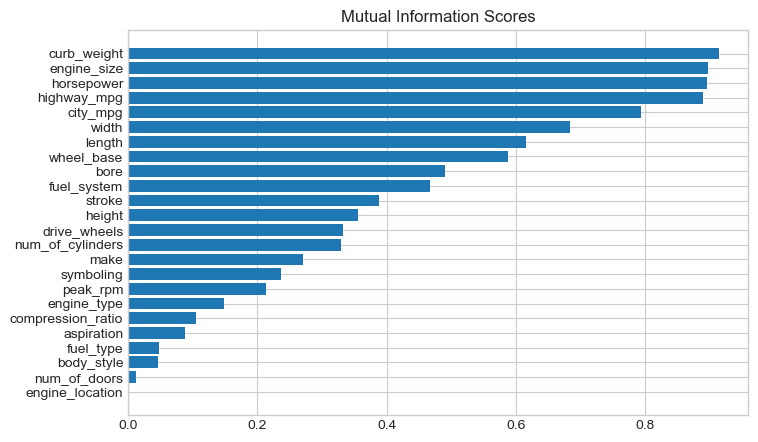

In [4]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

La visualización de datos es un excelente seguimiento para un ranking de utilidad. Echemos un vistazo más de cerca a un par de ellos.

Como podríamos esperar, la característica de alto puntaje, `curb_weight`, muestra una fuerte relación con `price`, el objetivo.


c:\Users\victo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


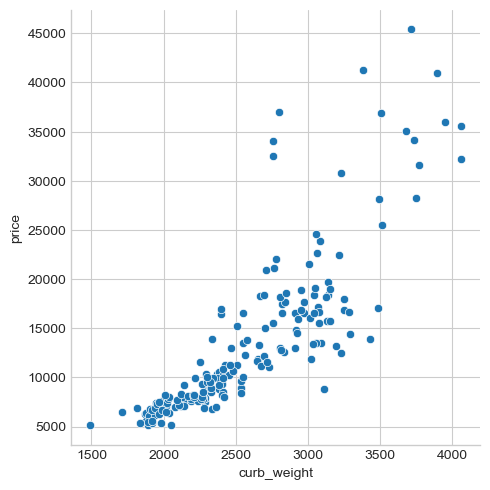

In [5]:
sns.relplot(x="curb_weight", y="price", data=df);

La característica `fuel_type` tiene un puntaje de IM bastante bajo, pero como podemos ver en la figura, claramente separa dos poblaciones de `price` con tendencias diferentes dentro de la característica `horsepower`. Esto indica que `fuel_type` contribuye a un efecto de interacción y podría no ser tan insignificante después de todo. Antes de decidir que una característica no es importante según su puntaje de IM, es bueno investigar posibles efectos de interacción; el conocimiento del dominio puede ofrecer mucha orientación en este sentido.


c:\Users\victo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


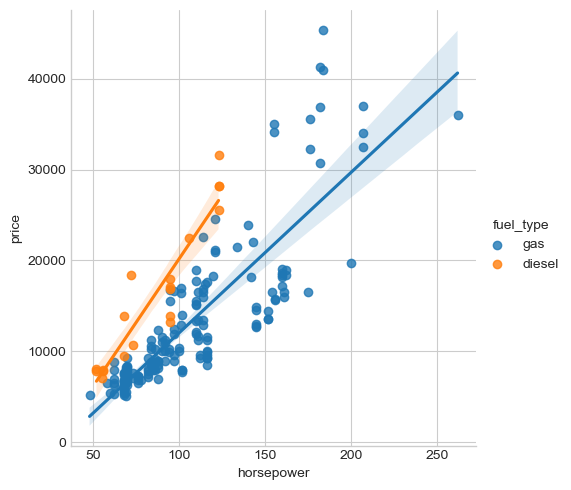

In [6]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df);

La visualización de datos es una gran adición a tu caja de herramientas de ingeniería de características. Junto con métricas de utilidad como la información mutua, visualizaciones como estas pueden ayudarte a descubrir relaciones importantes en tus datos. ¡Consulta nuestro curso de [Visualización de Datos](https://www.kaggle.com/learn/data-visualization) para aprender más!

# ¡Te toca a ti!

[**Clasifica las características**](https://www.kaggle.com/kernels/fork/14393925) del conjunto de datos de *Ames Housing* y elige tu primer conjunto de características para comenzar a desarrollar.


---

*¿Tienes preguntas o comentarios? Visita el [foro de discusión del curso](https://www.kaggle.com/learn/feature-engineering/discussion) para charlar con otros estudiantes.*

